In [637]:
%matplotlib inline
import os
import pickle
import string

import numpy as np

import matplotlib.pyplot as plt

from collections import defaultdict

from scipy.special import gamma
from scipy.spatial import cKDTree
from sklearn.neighbors import KDTree

import warnings
warnings.filterwarnings("ignore")

In [676]:
model_names = os.listdir("models")
model_names = model_names

### Data

In [4]:
class RungeKutta:
    """
    Implementation of 4th order Runge-Kutta integration
    """

    def __init__(self, beta, rho, sigma, dt):
        self.beta = beta
        self.rho = rho
        self.sigma = sigma
        self.dt = dt

    def deriviation_step(self, initial_state, derivative, dt):
        """
        Compute one evaluation step
        """

        # evaluation of state
        state = {}

        if not derivative:
            state["x"] = initial_state["x"]
            state["y"] = initial_state["y"]
            state["z"] = initial_state["z"]
        else:
            state["x"] = initial_state["x"] + derivative["dx"] * dt
            state["y"] = initial_state["y"] + derivative["dy"] * dt
            state["z"] = initial_state["z"] + derivative["dz"] * dt

        # evaluation of derivative
        derivative_next_step = {}

        derivative_next_step["dx"] = self.sigma * (state["y"] - state["x"])
        derivative_next_step["dy"] = self.rho * state["x"] - state["y"] - state["x"] * state["z"]
        derivative_next_step["dz"] = state["x"] * state["y"] - self.beta * state["z"]

        return derivative_next_step

    def _integration_step(self, state, dt):
        """
        Runge-Kutta integration of the 4th order at a time `t` with a state `state`
        with the step `dt`
        """
        # Prepare 1,2,3,4 - order derivatives for the final "best" derivative,
        # gained as 4 first elements of the Taylor's approximation

        # Random initialization of defivatives(probably will have to moove)
        derivative = dict({"dx": np.random.normal(),
                           "dy": np.random.normal(),
                           "dz": np.random.normal()})
        rk1 = self.deriviation_step(initial_state=state,
                                    derivative=None,
                                    dt=dt * 0)

        rk2 = self.deriviation_step(initial_state=state,
                                    derivative=rk1,
                                    dt=dt * 0.5
                                    )

        rk3 = self.deriviation_step(initial_state=state,
                                    derivative=rk2,
                                    dt=dt * 0.5)

        rk4 = self.deriviation_step(initial_state=state,
                                    derivative=rk3,
                                    dt=dt)

        # When all derivatives are ready, it's time to construct Rung-Kutta derivative
        # !!!! DOUBLE CHECK THE TAYLOR'S APPROXIMATIONS !!!!
        dxdt = (1 / 6) * (rk1["dx"] + 2 * rk2["dx"] + 2 * rk3["dx"] + rk4["dx"])
        dydt = (1 / 6) * (rk1["dy"] + 2 * rk2["dy"] + 2 * rk3["dy"] + rk4["dy"])
        dzdt = (1 / 6) * (rk1["dz"] + 2 * rk2["dz"] + 2 * rk3["dz"] + rk4["dz"])

        state["x"] = state["x"] + dxdt * dt
        state["y"] = state["y"] + dydt * dt
        state["z"] = state["z"] + dzdt * dt
        return state

    def get_series(self, n_iterations, initial_state=None):
        """
        Does a series of integration steps to get a series
        :return: numpy array of series
        """
        if not initial_state:
            initial_state = dict({"x": 0.62225717,
                                  "y": -0.08232857,
                                  "z": 30.60845379})

        ode_solutions = []
        for iteration in range(0, n_iterations):
            state_t = self._integration_step(initial_state, dt=self.dt)
            ode_solutions.append(list(state_t.values()))
        result = np.array(ode_solutions)
        return result[:, 0]


def reconstruct_lorenz(ts: np.ndarray, template: np.ndarray):
    ts_list = [ts[:-np.sum(template)].reshape(-1, 1)]

    for offset in template.cumsum()[:-1]:
        offset_ts = ts[offset:-(template.sum() - offset)].reshape(-1, 1)
        ts_list.append(offset_ts)
    ts_list.append(ts[np.sum(template):].reshape(-1, 1))
    reconstructed_ts = np.concatenate(ts_list, axis=1)
    return reconstructed_ts

In [48]:
def query_template_from_ts(ts: np.ndarray, template ) -> np.ndarray:
    """
    Queries a template sample from the time_series to make prediction with corresponding KDTree
    For example, if template is [2,2,3,2] and time series is [...,0,1,2,3,4,5,6,7,8,9], and
    we have to predict the next point: [...,0,1,2,3,4,5,6,7,8,9,x_to_predict],
    then the queried result would be [1, 3, 5, 8]

    :param ts:
    :param template:

    :return:
    """
    # Turning a template into indexing array
    template_reverse_indexing = np.cumsum(template[::-1])
    return ts[-template_reverse_indexing][::-1]


def parse_model_name(model_name: str):
    """
    Parse the name of the model file and extracts the template distances from it
    :param model_name: filename; e.g.: lorenz_5_2_5_6.pkl
    :return: list with template distances
    """
    def f(x):
        if x.isdigit():
            return int(x)
        else:
            return 10
    model_name = model_name.split("_")
    # Get rid of the name
    template_distances = list(map(f, model_name))
    return template_distances




### Rsearch

- Demon
- Simple prediction
    - Mean
    - Weighted mean
- Std research

In [9]:
rk = RungeKutta(beta=8 / 3, rho=28, sigma=10, dt=0.1)
lorenz_full = rk.get_series(n_iterations=int(1e6))
lorenz_full = lorenz_full / abs(lorenz_full.max())
lorenz_test = lorenz_full[int(5e5):]

#### Demon

In [542]:
N_POINTS = 1550
N_STEPS_FORWARD = 50
EPS = 0.3
result = []
EPS = 0.3
for EPS_DEMON in [0.005, 0.01, 0.05, 0.1]:
    result_mae_total = []
    for time_index in range(50, N_POINTS, 10):

        ts_to_predict = lorenz_test[:time_index]
        result_mae = []

        for step_forward in range(N_STEPS_FORWARD):

            true_value = lorenz_test[time_index + step_forward]
            cluster_predictions = []
            cluster_sizes = []

            for model_name in model_names:

                path_to_model = "models/" + model_name

                with open(path_to_model, "rb") as f:
                    model = pickle.load(f)
                    template_name = model["template_name"]
                    template = parse_model_name(template_name)
                    model_tree = model["kdtree"]
                    model_cluster_sizes = model["cluster_sizes"]
                    model_cluster_predictions = model["predicted_values"]

                zvector = query_template_from_ts(ts_to_predict, template)
                distance, nearest_cluster = model_tree.query(zvector, distance_upper_bound=EPS)
                if distance != np.inf:
                    cluster_prediction = model_cluster_predictions[nearest_cluster]
                    cluster_size = model_cluster_sizes[nearest_cluster]
                else:
                    pass
                    cluster_prediction = np.nan
                    cluster_size = np.nan
                if abs(cluster_prediction - true_value) > EPS_DEMON:
                    cluster_predictions.append(np.nan)
                    cluster_sizes.append(np.nan)
                else:
                    cluster_predictions.append(cluster_prediction)
                    cluster_sizes.append(cluster_size)
                
            final_step_prediction = np.nanmean(cluster_predictions)
            if final_step_prediction is np.nan:
                result_mae.append(np.nan)
            else:
                result_mae.append(abs(final_step_prediction - true_value))

            ts_to_predict = np.append(ts_to_predict, final_step_prediction)
        result_mae_total.append(result_mae)
    result.append(result_mae_total)

/home/waryak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice


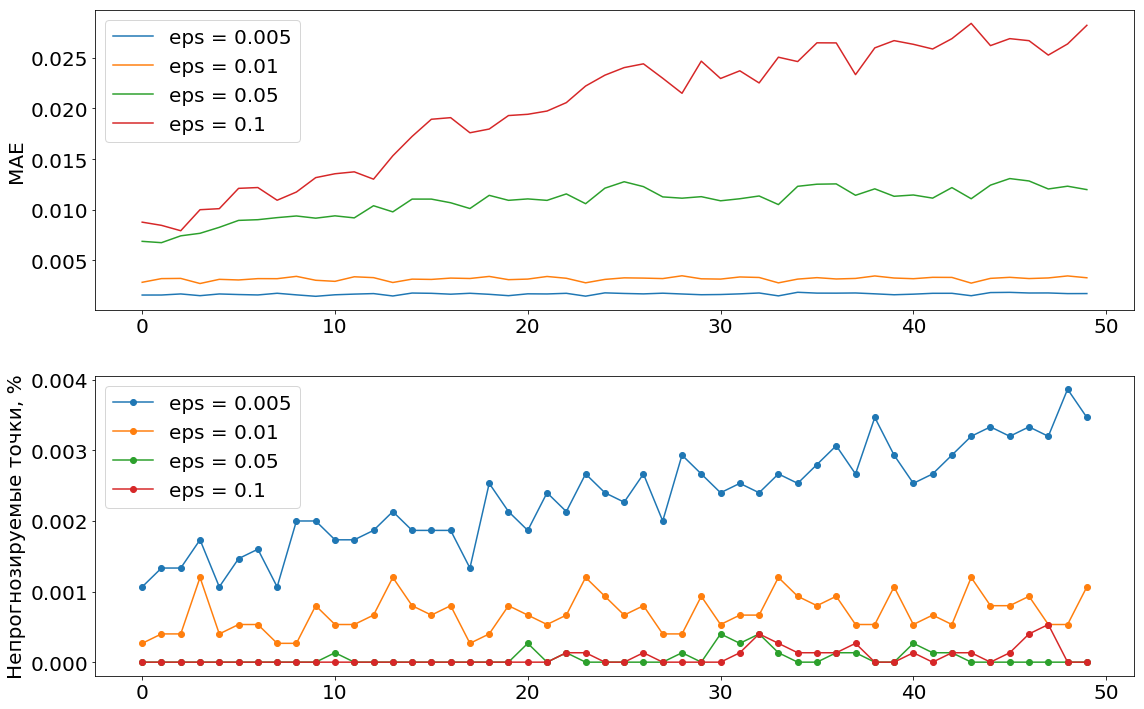

In [546]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 10)) 
axes[0].plot(np.nanmean(np.array(result[0]),0));
axes[0].plot(np.nanmean(np.array(result[1]),0));
axes[0].plot(np.nanmean(np.array(result[2]),0));
axes[0].plot(np.nanmean(np.array(result[3]),0));

axes[0].set_ylabel("MAE", fontsize=20);
axes[0].tick_params(labelsize=20)

axes[1].plot(np.isnan(np.array(result[0])).sum(0) / 7500, "-o" )
axes[1].plot(np.isnan(np.array(result[1])).sum(0) / 7500, "-o" )
axes[1].plot(np.isnan(np.array(result[2])).sum(0) / 7500, "-o" )
axes[1].plot(np.isnan(np.array(result[3])).sum(0) / 7500, "-o" )

axes[1].set_ylabel("Непрогнозируемые точки, %", fontsize=20);
axes[1].tick_params(labelsize=20)

axes[0].legend(["eps = 0.005", "eps = 0.01", "eps = 0.05", "eps = 0.1"], fontsize=20)
axes[1].legend(["eps = 0.005", "eps = 0.01", "eps = 0.05", "eps = 0.1"], fontsize=20)

fig.tight_layout()
fig.savefig("demon.png")

#### Accuracy measuring

In [678]:
N_POINTS = 1050
N_STEPS_FORWARD = 50
EPS = 0.3
result = []
for EPS in [0.1, 0.3, 0.5]:
    result_mae_total = []
    for time_index in range(50, N_POINTS, 10):

        ts_to_predict = lorenz_test[:time_index]
        result_mae = []

        for step_forward in range(N_STEPS_FORWARD):

            true_value = lorenz_test[time_index + step_forward]
            cluster_predictions = []
            cluster_sizes = []

            for model_name in model_names:

                path_to_model = "models/" + model_name

                with open(path_to_model, "rb") as f:
                    model = pickle.load(f)
                    template_name = model["template_name"]
                    template = parse_model_name(template_name)
                    model_tree = model["kdtree"]
                    model_cluster_sizes = model["cluster_sizes"]
                    model_cluster_predictions = model["predicted_values"]

                zvector = query_template_from_ts(ts_to_predict, template)
                distance, nearest_cluster = model_tree.query(zvector, distance_upper_bound=EPS)
                if distance != np.inf:
                    cluster_prediction = model_cluster_predictions[nearest_cluster]
                    cluster_size = model_cluster_sizes[nearest_cluster]
                    cluster_predictions.append(cluster_prediction)
                    cluster_sizes.append(cluster_size)
                else:
                    pass
                    cluster_prediction = np.nan
                    cluster_size = np.nan
                    
                cluster_predictions.append(cluster_prediction)
                cluster_sizes.append(cluster_size)
                
#             cluster_predictions = np.array(cluster_predictions)
#             cluster_sizes = np.array(cluster_sizes)
            final_step_prediction = cluster_predictions @ cluster_sizes / cluster_sizes.sum()
#             final_step_prediction = np.nanmean(cluster_predictions)
            result_mae.append(abs(final_step_prediction - true_value))

            ts_to_predict = np.append(ts_to_predict, final_step_prediction)
        result_mae_total.append(result_mae)
    result.append(result_mae_total)

---

График точности взависимости от `eps` для прогноза по `mean`

In [679]:
result_mean = result.copy()

In [700]:
np.sum(result_mean[0]), np.sum(result_weighted_mean[0])

(613.5281067943552, 613.5281067943552)

In [695]:
result_weighted_mean = result.copy()

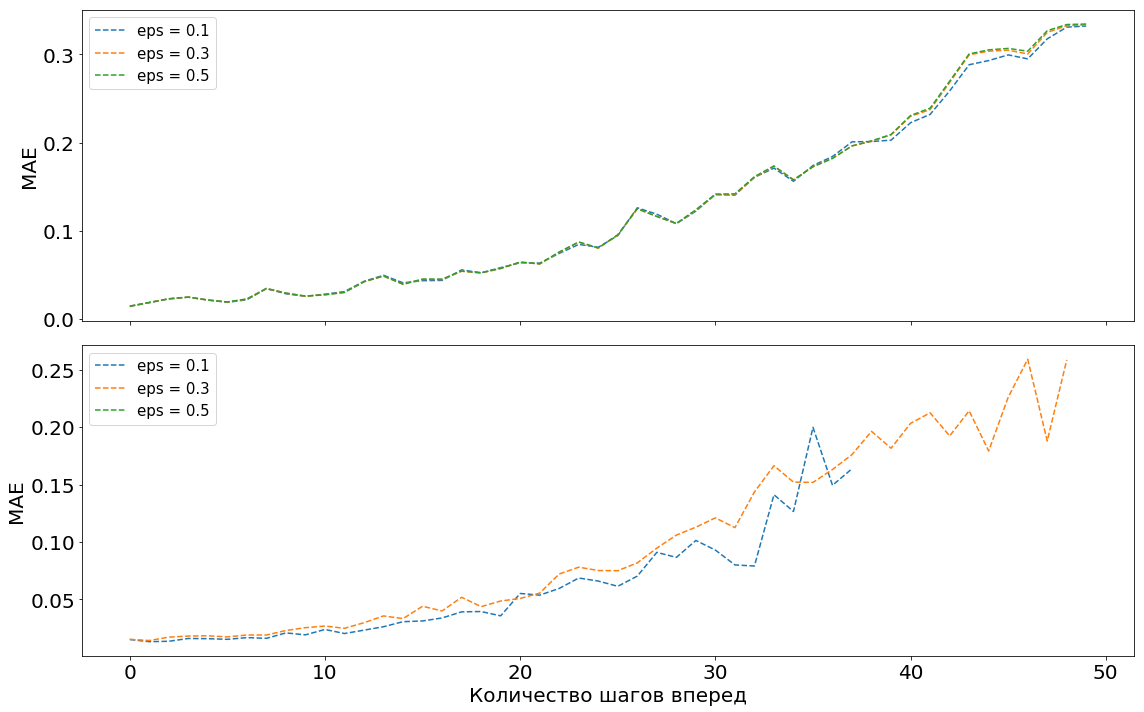

In [673]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 10), sharex=True) 
axes[0].plot(np.array(result_mean[0]).mean(0), '--');
axes[0].plot(np.array(result_mean[1]).mean(0), '--');
axes[0].plot(np.array(result_mean[2]).mean(0), '--');
axes[0].set_ylabel("MAE", fontsize=20);
axes[0].legend(["eps = 0.1", "eps = 0.3", "eps = 0.5"], fontsize=15)
axes[0].tick_params(labelsize=20)

axes[1].plot(np.nanmean(np.array(result[0]), 0), '--');
axes[1].plot(np.nanmean(np.array(result[1]), 0), '--');
axes[1].plot(np.array(result[2]).mean(0), '--');
axes[1].set_ylabel("MAE", fontsize=20);
axes[1].legend(["eps = 0.1", "eps = 0.3", "eps = 0.5"], fontsize=15)
axes[1].tick_params(labelsize=20)
axes[1].set_xlabel("Количество шагов вперед", fontsize=20);

fig.tight_layout()
fig.savefig("mean_weighted.png")

---

График точности взависимости от `eps` для прогноза по `weighted mean by cluster sizes`

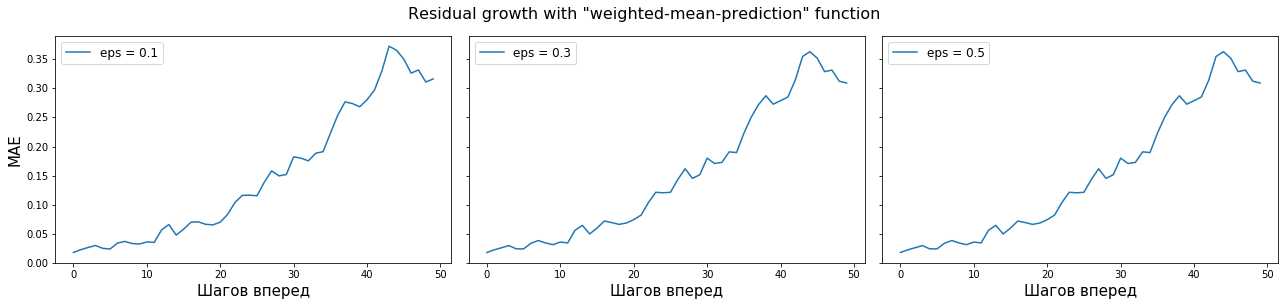

In [216]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4), sharey=True) 
axes[0].plot(np.array(result[0]).mean(0));
axes[1].plot(np.array(result[1]).mean(0));
axes[2].plot(np.array(result[1]).mean(0));
axes[0].set_ylabel("MAE", fontsize=15);
axes[0].set_xlabel("Шагов вперед", fontsize=15);
axes[1].set_xlabel("Шагов вперед", fontsize=15);
axes[2].set_xlabel("Шагов вперед", fontsize=15);
axes[0].legend(["eps = 0.1"], fontsize=12)
axes[1].legend(["eps = 0.3"], fontsize=12)
axes[2].legend(["eps = 0.5"], fontsize=12)
fig.suptitle("Residual growth with \"weighted-mean-prediction\" function", fontsize=16, y=1.05);
fig.tight_layout()
fig.savefig("weighted_mean_1.png")

---

#### Testing prediction abortion

In [701]:
N_POINTS = 1550
N_STEPS_FORWARD = 50
EPS = 0.3
result = []
stds = []
for EPS in [0.1, 0.3]:
    result_mae_total = []
    time_stds = []
    for time_index in range(50, N_POINTS, 10):

        ts_to_predict = lorenz_test[:time_index]
        result_mae = []
        prediction_step_stds = []
        for step_forward in range(N_STEPS_FORWARD):

            true_value = lorenz_test[time_index + step_forward]
            cluster_predictions = []
            cluster_sizes = []

            for model_name in model_names:

                path_to_model = "models/" + model_name

                with open(path_to_model, "rb") as f:
                    model = pickle.load(f)
                    template_name = model["template_name"]
                    template = parse_model_name(template_name)
                    model_tree = model["kdtree"]
                    model_cluster_sizes = model["cluster_sizes"]
                    model_cluster_predictions = model["predicted_values"]

                zvector = query_template_from_ts(ts_to_predict, template)
                distance, nearest_cluster = model_tree.query(zvector, distance_upper_bound=EPS)
                if distance != np.inf:
                    cluster_prediction = model_cluster_predictions[nearest_cluster]
                    cluster_size = model_cluster_sizes[nearest_cluster]
                else:
                    pass
                    cluster_prediction = np.nan
                    cluster_size = np.nan
                    
                cluster_predictions.append(cluster_prediction)
                cluster_sizes.append(cluster_size)
                
            final_step_prediction = np.nanmean(cluster_predictions)
            prediction_step_std = np.nanstd(cluster_predictions)
            result_mae.append(abs(final_step_prediction - true_value))
            prediction_step_stds.append(prediction_step_std)
            
            ts_to_predict = np.append(ts_to_predict, final_step_prediction)
            
        result_mae_total.append(result_mae)
        time_stds.append(prediction_step_stds)
    result.append(result_mae_total)
    stds.append(time_stds)

In [459]:
s1 = np.array(stds[0])
s2 = np.array(stds[1])
r1 = np.array(result[0])
r2 = np.array(result[1])
print("Correlation for eps=0.1", np.corrcoef((s1.mean(1), np.array(result[0]).mean(1)))[0][1])
print("Correlation for eps=0.3", np.corrcoef((s2.mean(1), np.array(result[1]).mean(1)))[0][1])

Correlation for eps=0.1 0.5044022756994666
Correlation for eps=0.3 0.48866503747263884


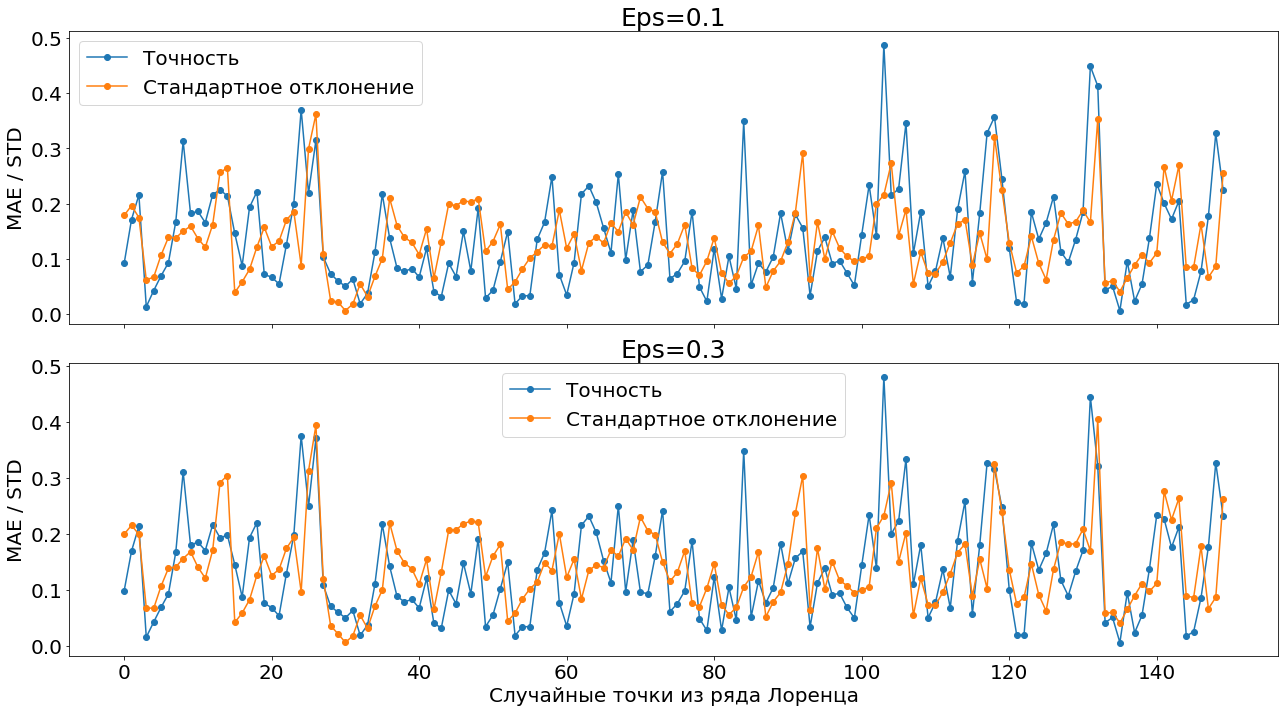

In [705]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 10), sharex=True) 
axes[0].plot(np.array(result[0]).mean(1), "-o");
axes[0].plot(s1.mean(1), "-o");

axes[0].tick_params(labelsize=20)
axes[0].set_ylabel("MAE / STD", fontsize=20);
axes[0].legend(["Точность", "Стандартное отклонение"], fontsize=20)
axes[0].set_title("Eps=0.1", fontsize=25)

axes[1].plot(np.array(result[1]).mean(1), "-o");
axes[1].plot(s2.mean(1), "-o");

axes[1].tick_params(labelsize=20)
axes[1].set_ylabel("MAE / STD", fontsize=20);
axes[1].legend(["Точность", "Стандартное отклонение"], fontsize=20)
axes[1].set_xlabel("Случайные точки из ряда Лоренца", fontsize=20);
axes[1].set_title("Eps=0.3", fontsize=25)

fig.tight_layout()
fig.savefig("std_analyse.png")

НЕусредненное стандартное откллонение и точность

In [706]:
s1_flat = s1.flatten()
s2_flat = s2.flatten()
r1_flat = r1.flatten()
r2_flat = r2.flatten()
print("Correlation for eps=0.1", np.corrcoef(s1_flat, r1_flat)[0][1])
print("Correlation for eps=0.3", np.corrcoef(s2_flat, r2_flat)[0][1])

Correlation for eps=0.1 0.47484655900053685
Correlation for eps=0.3 0.49711391440808983


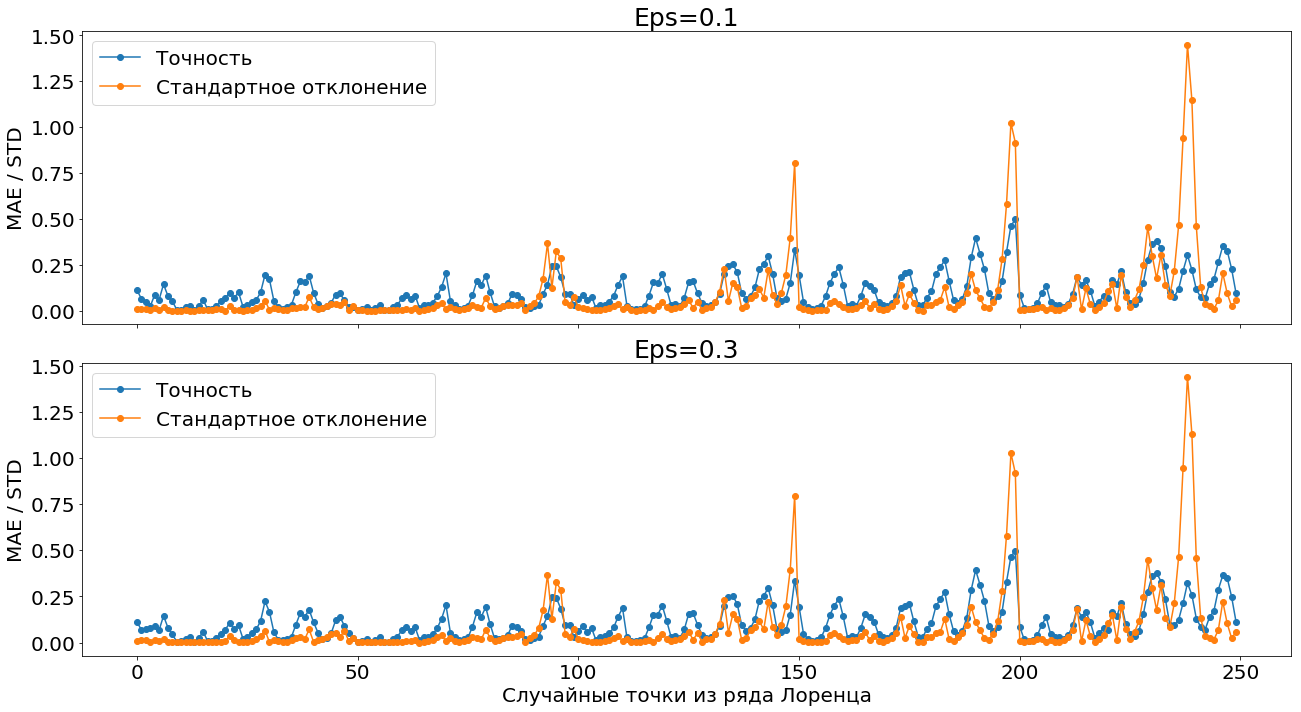

In [707]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 10), sharex=True) 
axes[0].plot(s1_flat[150:400], "-o");
axes[0].plot(r1_flat[150:400], "-o");

axes[0].tick_params(labelsize=20)
axes[0].set_ylabel("MAE / STD", fontsize=20);
axes[0].legend(["Точность", "Стандартное отклонение"], fontsize=20)
axes[0].set_title("Eps=0.1", fontsize=25)

axes[1].plot(s2_flat[150:400], "-o");
axes[1].plot(r2_flat[150:400], "-o");

axes[1].tick_params(labelsize=20)
axes[1].set_ylabel("MAE / STD", fontsize=20);
axes[1].legend(["Точность", "Стандартное отклонение"], fontsize=20)
axes[1].set_xlabel("Случайные точки из ряда Лоренца", fontsize=20);
axes[1].set_title("Eps=0.3", fontsize=25)

fig.tight_layout()
fig.savefig("std_analyse_2.png")

Fit the linear regression 

For eps = 0.1

In [709]:
steps = np.array(range(1,51))
steps = np.tile(steps, 150)
data_X = np.concatenate([s1_flat.reshape(-1, 1), steps.reshape(-1, 1)], 1)

In [524]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

lr1 = LinearRegression()
lr1.fit(data_X[:5500], r1_flat[:5500])
predicted = lr1.predict(data_X[5500:])
print("Simple linear regression - MAE: ", mean_absolute_error(predicted, r1_flat[5500:]), " MSE: ", mean_squared_error(predicted, r1_flat[5500:]))

lrr1 = Ridge(0.5)
lrr1.fit(data_X[:5500], r1_flat[:5500])
predicted = lrr1.predict(data_X[5500:])
print("Simple linear regression - MAE: ", mean_absolute_error(predicted, r1_flat[5500:]), " MSE: ", mean_squared_error(predicted, r1_flat[5500:]))

lrs1 = Lasso(0.5)
lrs1.fit(data_X[:5500], r1_flat[:5500])
predicted = lrs1.predict(data_X[5500:])
print("Simple linear regression - MAE: ", mean_absolute_error(predicted, r1_flat[5500:]), " MSE: ", mean_squared_error(predicted, r1_flat[5500:]))

Simple linear regression - MAE:  0.12303948366903936  MSE:  0.04838020663340859
Simple linear regression - MAE:  0.12304160642140226  MSE:  0.048397555354648195
Simple linear regression - MAE:  0.14304597103610955  MSE:  0.061116267634998084


For esp = 0.3

In [711]:
steps = np.array(range(1,51))
steps = np.tile(steps, 150)
data_X = np.concatenate([s2_flat.reshape(-1, 1), steps.reshape(-1, 1)], 1)

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

lr2 = LinearRegression()
lr2.fit(data_X[:5500], r2_flat[:5500])
predicted = lr2.predict(data_X[5500:])
print("Simple linear regression - MAE: ", mean_absolute_error(predicted, r2_flat[5500:]), " MSE: ", mean_squared_error(predicted, r2_flat[5500:]))

lrr2 = Ridge(0.5)
lrr2.fit(data_X[:5500], r2_flat[:5500])
predicted = lrr2.predict(data_X[5500:])
print("Simple linear regression - MAE: ", mean_absolute_error(predicted, r2_flat[5500:]), " MSE: ", mean_squared_error(predicted, r2_flat[5500:]))

lrs2 = Lasso(0.5)
lrs2.fit(data_X[:5500], r2_flat[:5500])
predicted = lrs2.predict(data_X[5500:])
print("Simple linear regression - MAE: ", mean_absolute_error(predicted, r2_flat[5500:]), " MSE: ", mean_squared_error(predicted, r2_flat[5500:]))

Simple linear regression - MAE:  0.12389128434514692  MSE:  0.04871895864847006
Simple linear regression - MAE:  0.1238661401243584  MSE:  0.048710699968256436
Simple linear regression - MAE:  0.13925626675353697  MSE:  0.057886468363535754


#### Using linear regression to cancel predictions

In [712]:
N_POINTS = 2550
N_STEPS_FORWARD = 50
EPS = 0.3
result = []
stds = []
for EPS_MAE in [0.1, 0.15, 0.2, 0.25]:
    result_mae_total = []
    time_stds = []
    for time_index in range(50, N_POINTS, 10):

        ts_to_predict = lorenz_test[:time_index]
        result_mae = []
        prediction_step_stds = []
        for step_forward in range(N_STEPS_FORWARD):

            true_value = lorenz_test[time_index + step_forward]
            cluster_predictions = []
            cluster_sizes = []

            for model_name in model_names:

                path_to_model = "models/" + model_name

                with open(path_to_model, "rb") as f:
                    model = pickle.load(f)
                    template_name = model["template_name"]
                    template = parse_model_name(template_name)
                    model_tree = model["kdtree"]
                    model_cluster_sizes = model["cluster_sizes"]
                    model_cluster_predictions = model["predicted_values"]

                zvector = query_template_from_ts(ts_to_predict, template)
                distance, nearest_cluster = model_tree.query(zvector, distance_upper_bound=EPS)
                if distance != np.inf:
                    cluster_prediction = model_cluster_predictions[nearest_cluster]
                    cluster_size = model_cluster_sizes[nearest_cluster]
                else:
                    pass
                    cluster_prediction = np.nan
                    cluster_size = np.nan
                    
                cluster_predictions.append(cluster_prediction)
                cluster_sizes.append(cluster_size)
                
            final_step_prediction = np.nanmean(cluster_predictions)
            prediction_step_std = np.nanstd(cluster_predictions)
            # ------ ML ------
            prediction_vector = np.array([prediction_step_std, step_forward+1]).reshape(1, -1)
            if np.isnan(cluster_predictions).all():
                # No predictions from any templates - skip this prediction by setting MAE too big
                mae_prediction = EPS_MAE + 1000 
            else:
                mae_prediction = lr1.predict(prediction_vector)
            # ------ ML ------
            if mae_prediction < EPS_MAE:
                result_mae.append(abs(final_step_prediction - true_value))
                prediction_step_stds.append(prediction_step_std)
                ts_to_predict = np.append(ts_to_predict, final_step_prediction)
            else:
                result_mae.append(np.nan)
                prediction_step_stds.append(prediction_step_std)
                ts_to_predict = np.append(ts_to_predict, np.nan)
            
        result_mae_total.append(result_mae)
        time_stds.append(prediction_step_stds)
    result.append(result_mae_total)
    stds.append(time_stds)

In [713]:
result01 = result.copy()

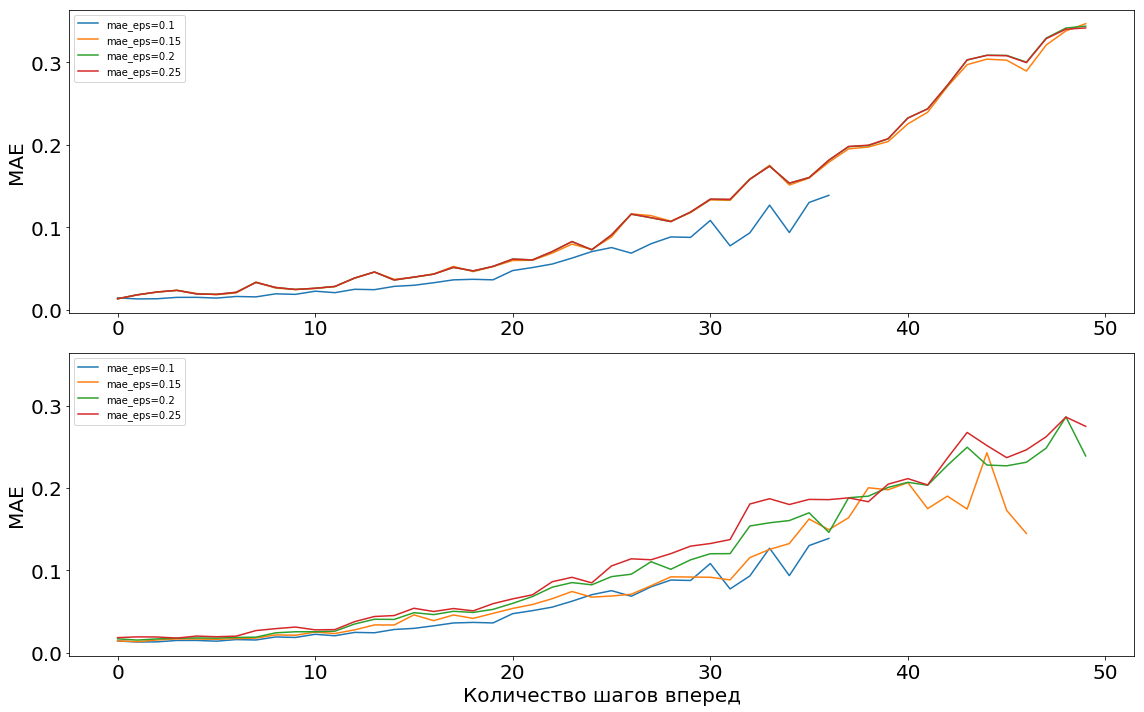

In [756]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 10), sharey=True) 

axes[0].plot(np.nanmean(np.array(result01[0]), 0));
# axes[0].plot(np.nanmean(np.array(result01[1]), 0));
# axes[0].plot(np.nanmean(np.array(result01[2]), 0));
# axes[0].plot(np.nanmean(np.array(result01[3]), 0));

axes[0].plot(np.nanmean(np.array(result_mean[0]), 0));
axes[0].plot(np.nanmean(np.array(result_mean[1]), 0));
axes[0].plot(np.nanmean(np.array(result_mean[2]), 0));
# axes[0].plot(np.nanmean(np.array(result[3]), 0));


axes[0].legend(["mae_eps=0.1", "mae_eps=0.15", "mae_eps=0.2", "mae_eps=0.25"])
axes[0].set_ylabel("MAE", fontsize=20);
axes[0].tick_params(labelsize=20)


axes[1].plot(np.nanmean(np.array(result[0]), 0));
axes[1].plot(np.nanmean(np.array(result[1]), 0));
axes[1].plot(np.nanmean(np.array(result[2]), 0));
axes[1].plot(np.nanmean(np.array(result[3]), 0));

axes[1].legend(["mae_eps=0.1", "mae_eps=0.15", "mae_eps=0.2", "mae_eps=0.25"])
axes[1].set_ylabel("MAE", fontsize=20);
axes[1].set_xlabel("Количество шагов вперед", fontsize=20);
axes[1].tick_params(labelsize=20)


fig.tight_layout()
fig.savefig("modified.png")

In [757]:
a = np.nanmean(np.array(result01[0]), 0)
b = np.nanmean(np.array(result_mean[0]), 0)

In [768]:
2.603048401608655 / 1.9046165235128512

1.3667047247955324

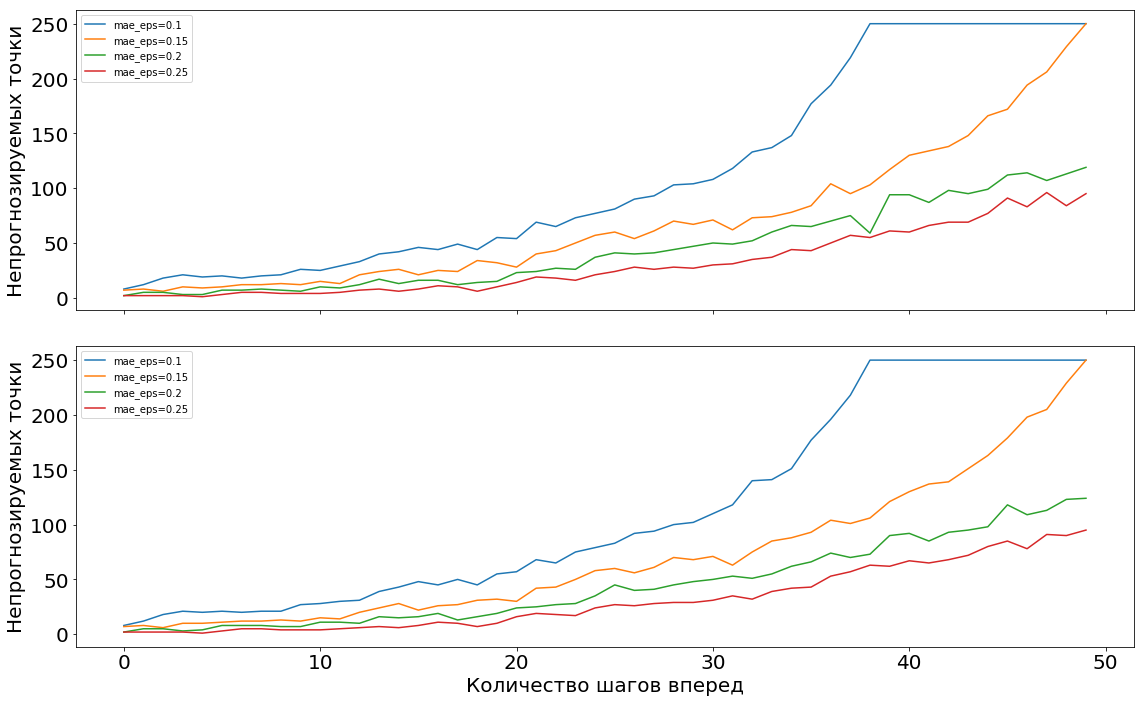

In [666]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 10), sharey=True, sharex=True) 

axes[0].plot(np.isnan(np.array(result01[0])).sum(0));
axes[0].plot(np.isnan(np.array(result01[1])).sum(0));
axes[0].plot(np.isnan(np.array(result01[2])).sum(0));
axes[0].plot(np.isnan(np.array(result01[3])).sum(0));

axes[0].legend(["mae_eps=0.1", "mae_eps=0.15", "mae_eps=0.2", "mae_eps=0.25"])
axes[0].set_ylabel("Непрогнозируемых точки", fontsize=20);
axes[0].tick_params(labelsize=20)


axes[1].plot(np.isnan(np.array(result[0])).sum(0));
axes[1].plot(np.isnan(np.array(result[1])).sum(0));
axes[1].plot(np.isnan(np.array(result[2])).sum(0));
axes[1].plot(np.isnan(np.array(result[3])).sum(0));

axes[1].legend(["mae_eps=0.1", "mae_eps=0.15", "mae_eps=0.2", "mae_eps=0.25"])
axes[1].set_ylabel("Непрогнозируемых точки", fontsize=20);
axes[1].set_xlabel("Количество шагов вперед", fontsize=20);
axes[1].tick_params(labelsize=20)


fig.tight_layout()
fig.savefig("modified_unpredictable.png")

#### Decision tree

In [738]:
steps = np.array(range(1,51))
steps = np.tile(steps, 150)
data_X = np.concatenate([s2_flat.reshape(-1, 1), steps.reshape(-1, 1)], 1)

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

dt = DecisionTreeRegressor(criterion="mse")
dt.fit(data_X[:5500], r2_flat[:5500])
predicted = dt.predict(data_X[5500:])
print("Simple decision tree - MAE: ", mean_absolute_error(predicted, r2_flat[5500:]), " MSE: ", mean_squared_error(predicted, r2_flat[5500:]))

rf = RandomForestRegressor(n_estimators=5, max_depth=2)
rf.fit(data_X[:5500], r2_flat[:5500])
predicted = rf.predict(data_X[5500:])
print("Simple random forest - MAE: ", mean_absolute_error(predicted, r2_flat[5500:]), " MSE: ", mean_squared_error(predicted, r2_flat[5500:]))


Simple decision tree - MAE:  0.1468366212148116  MSE:  0.08173046303824541
Simple random forest - MAE:  0.1202098946614886  MSE:  0.0508457877907398


In [ ]:
N_POINTS = 2550
N_STEPS_FORWARD = 50
EPS = 0.3
result = []
stds = []
for EPS_MAE in [0.1, 0.15, 0.2, 0.25]:
    result_mae_total = []
    time_stds = []
    for time_index in range(50, N_POINTS, 10):

        ts_to_predict = lorenz_test[:time_index]
        result_mae = []
        prediction_step_stds = []
        for step_forward in range(N_STEPS_FORWARD):

            true_value = lorenz_test[time_index + step_forward]
            cluster_predictions = []
            cluster_sizes = []

            for model_name in model_names:

                path_to_model = "models/" + model_name

                with open(path_to_model, "rb") as f:
                    model = pickle.load(f)
                    template_name = model["template_name"]
                    template = parse_model_name(template_name)
                    model_tree = model["kdtree"]
                    model_cluster_sizes = model["cluster_sizes"]
                    model_cluster_predictions = model["predicted_values"]

                zvector = query_template_from_ts(ts_to_predict, template)
                distance, nearest_cluster = model_tree.query(zvector, distance_upper_bound=EPS)
                if distance != np.inf:
                    cluster_prediction = model_cluster_predictions[nearest_cluster]
                    cluster_size = model_cluster_sizes[nearest_cluster]
                else:
                    pass
                    cluster_prediction = np.nan
                    cluster_size = np.nan
                    
                cluster_predictions.append(cluster_prediction)
                cluster_sizes.append(cluster_size)
                
            final_step_prediction = np.nanmean(cluster_predictions)
            prediction_step_std = np.nanstd(cluster_predictions)
            # ------ ML ------
            prediction_vector = np.array([prediction_step_std, step_forward+1]).reshape(1, -1)
            if np.isnan(cluster_predictions).all():
                # No predictions from any templates - skip this prediction by setting MAE too big
                mae_prediction = EPS_MAE + 1000 
            else:
                mae_prediction = rf.predict(prediction_vector)
            # ------ ML ------
            if mae_prediction < EPS_MAE:
                result_mae.append(abs(final_step_prediction - true_value))
                prediction_step_stds.append(prediction_step_std)
                ts_to_predict = np.append(ts_to_predict, final_step_prediction)
            else:
                result_mae.append(np.nan)
                prediction_step_stds.append(prediction_step_std)
                ts_to_predict = np.append(ts_to_predict, np.nan)
            
        result_mae_total.append(result_mae)
        time_stds.append(prediction_step_stds)
    result.append(result_mae_total)
    stds.append(time_stds)

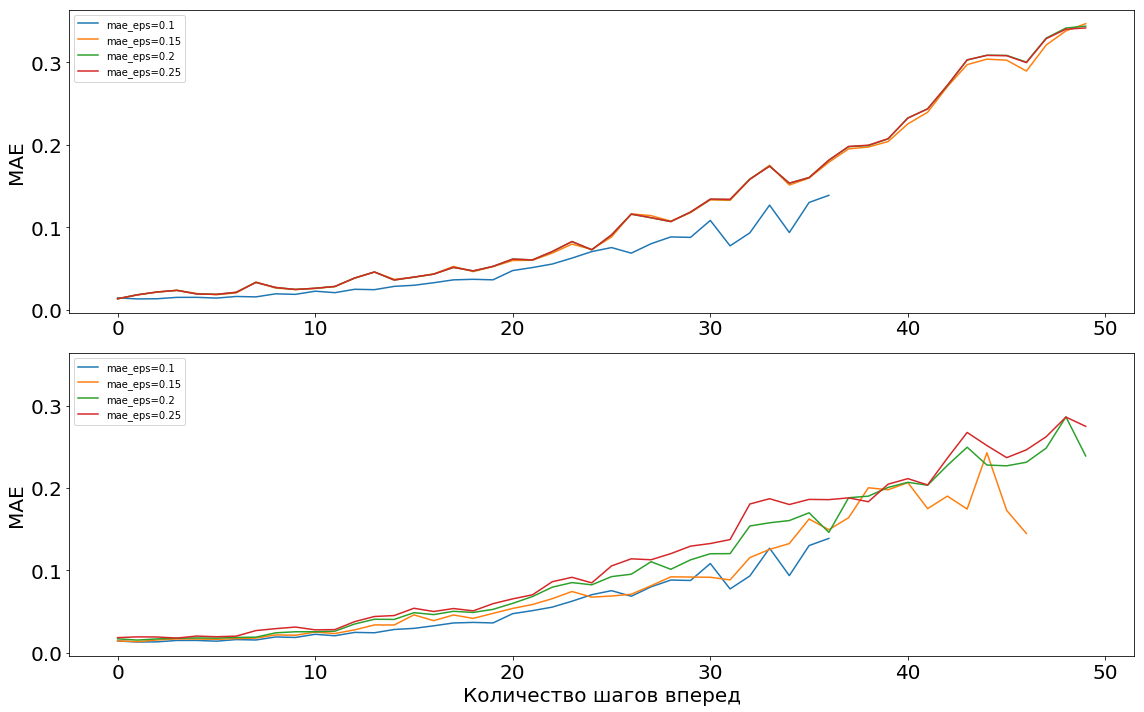

In [769]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 10), sharey=True) 

axes[0].plot(np.nanmean(np.array(result01[0]), 0));
# axes[0].plot(np.nanmean(np.array(result01[1]), 0));
# axes[0].plot(np.nanmean(np.array(result01[2]), 0));
# axes[0].plot(np.nanmean(np.array(result01[3]), 0));

axes[0].plot(np.nanmean(np.array(result_mean[0]), 0));
axes[0].plot(np.nanmean(np.array(result_mean[1]), 0));
axes[0].plot(np.nanmean(np.array(result_mean[2]), 0));
# axes[0].plot(np.nanmean(np.array(result[3]), 0));


axes[0].legend(["mae_eps=0.1", "mae_eps=0.15", "mae_eps=0.2", "mae_eps=0.25"])
axes[0].set_ylabel("MAE", fontsize=20);
axes[0].tick_params(labelsize=20)


axes[1].plot(np.nanmean(np.array(result[0]), 0));
axes[1].plot(np.nanmean(np.array(result[1]), 0));
axes[1].plot(np.nanmean(np.array(result[2]), 0));
axes[1].plot(np.nanmean(np.array(result[3]), 0));

axes[1].legend(["mae_eps=0.1", "mae_eps=0.15", "mae_eps=0.2", "mae_eps=0.25"])
axes[1].set_ylabel("MAE", fontsize=20);
axes[1].set_xlabel("Количество шагов вперед", fontsize=20);
axes[1].tick_params(labelsize=20)


fig.tight_layout()
fig.savefig("modified.png")

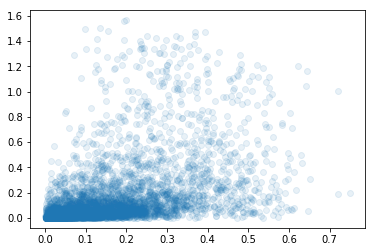

In [753]:
plt.plot(data_X[0:5500, 0], r2_flat[:5500], 'o', alpha=0.1)

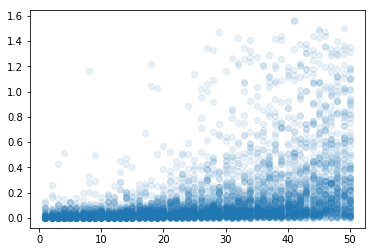

In [754]:
plt.plot(data_X[0:5500, 1], r2_flat[:5500], 'o', alpha=0.1)

#### Lorenz time-series

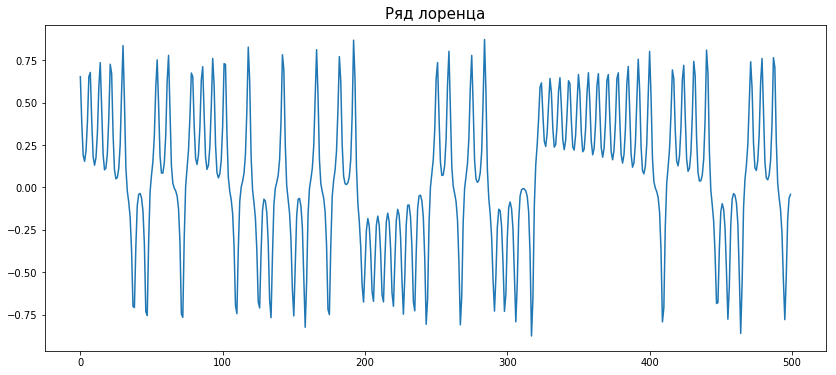

In [132]:
f = plt.figure(figsize=(14,6))
plt.plot(lorenz_test[:500])
plt.title("Ряд лоренца", fontsize=15)
plt.savefig("lorenz.png")